In [1]:
from google.colab import drive
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os
 
drive.mount('/content/drive')
 
SOURCE_PATH = "/content/drive/My Drive/ColabNotebooks/acnes_aug/"

Mounted at /content/drive


In [9]:
train_excoriated_dir = Path(SOURCE_PATH + 'train/excoriated')
train_excoriated = list(train_excoriated_dir.glob(r'**/*.JPG')) + list(train_excoriated_dir.glob(r'**/*.jpg'))

train_pustular_dir = Path(SOURCE_PATH + 'train/pustular')
train_pustular = list(train_pustular_dir.glob(r'**/*.JPG')) + list(train_pustular_dir.glob(r'**/*.jpg'))

train_cystic_dir = Path(SOURCE_PATH + 'train/cystic')
train_cystic = list(train_cystic_dir.glob(r'**/*.JPG')) + list(train_cystic_dir.glob(r'**/*.jpg'))

print("total training data of pustular acne : "+ str(len(train_pustular)))
print("total training data of excoriated acne : "+str(len(train_excoriated)))
print("total training data of cystic acne : "+str(len(train_cystic)))

training_data =  train_excoriated + train_pustular
print("total training data : " + str(len(training_data)))

total training data of pustular acne : 1600
total training data of excoriated acne : 1620
total training data of cystic acne : 1600
total training data : 3220


In [10]:
test_excoriated_dir = Path(SOURCE_PATH + 'test/excoriated')
test_excoriated = list(test_excoriated_dir.glob(r'**/*.JPG')) + list(test_excoriated_dir.glob(r'**/*.jpg'))


test_pustular_dir =  Path(SOURCE_PATH + 'test/pustular')
test_pustular =  list(test_pustular_dir.glob(r'**/*.JPG')) + list(test_pustular_dir.glob(r'**/*.jpg'))

testing_data =  test_excoriated + test_pustular 
for i in testing_data:
  print(i)

In [11]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name="Filepath").astype(str)
    labels = pd.Series(labels, name="Label")

    # concate the filpaths and labels
    df = pd.concat([filepath,labels], axis=1)

    # shuffle the DataFrame and resetIndex
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [12]:
train_df = proc_img(training_data)
test_df = proc_img(testing_data)


print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label}')


df_unique = train_df.copy().drop_duplicates(subset=['Label'])
df_unique = df_unique.reset_index()
print(df_unique.Filepath)
train_df.head(10)

Number of pictures: 3220

Number of different labels: 2

Labels: 0       excoriated
1       excoriated
2       excoriated
3       excoriated
4       excoriated
           ...    
3215    excoriated
3216    excoriated
3217    excoriated
3218      pustular
3219      pustular
Name: Label, Length: 3220, dtype: object
0    /content/drive/My Drive/ColabNotebooks/acnes_a...
1    /content/drive/My Drive/ColabNotebooks/acnes_a...
Name: Filepath, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,Filepath,Label
0,/content/drive/My Drive/ColabNotebooks/acnes_a...,excoriated
1,/content/drive/My Drive/ColabNotebooks/acnes_a...,excoriated
2,/content/drive/My Drive/ColabNotebooks/acnes_a...,excoriated
3,/content/drive/My Drive/ColabNotebooks/acnes_a...,excoriated
4,/content/drive/My Drive/ColabNotebooks/acnes_a...,excoriated
5,/content/drive/My Drive/ColabNotebooks/acnes_a...,excoriated
6,/content/drive/My Drive/ColabNotebooks/acnes_a...,excoriated
7,/content/drive/My Drive/ColabNotebooks/acnes_a...,excoriated
8,/content/drive/My Drive/ColabNotebooks/acnes_a...,pustular
9,/content/drive/My Drive/ColabNotebooks/acnes_a...,pustular


In [13]:
import tensorflow as tf
 
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2
)
 
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
)
 
train_images = train_generator.flow_from_dataframe(
    dataframe= train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size=(224,224),
    color_mode='rgb',
    #class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_image= 30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_images = train_generator.flow_from_dataframe(
    dataframe= train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size=(224,224),
    color_mode='rgb',
    #class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_image= 30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
 
 
 
#test_images = test_generator.flow_from_dataframe(
#    dataframe=test_df,
#    x_col='Filepath',
#    y_col='Label',
#    target_size=(224, 224),
#    color_mode='rgb',
#    #class_mode='binary',
#    batch_size=32,
#    shuffle=False
#)
 
pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    classes=1000,
    pooling="max"
)
 
pretrained_model.trainable = False
 
inputs = pretrained_model.input
 
x = tf.keras.layers.Dense(64 ,activation='relu')(pretrained_model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64 ,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64 ,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
 
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}): 
        if((logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9) 
        and (logs.get('loss') < 0.2 and logs.get("val_loss") < 0.25)):   
          self.model.stop_training = True
 
myCallback = Callback()

history = model.fit(
    train_images,
    validation_data= val_images,
    epochs=100,
    callbacks=[myCallback]
)

Found 2576 validated image filenames belonging to 2 classes.
Found 644 validated image filenames belonging to 2 classes.
Epoch 1/100
81/81 [==============================] - 824s 10s/step - loss: 0.9994 - accuracy: 0.5734 - val_loss: 0.5885 - val_accuracy: 0.6724
Epoch 2/100
81/81 [==============================] - 12s 150ms/step - loss: 0.7554 - accuracy: 0.6510 - val_loss: 0.5384 - val_accuracy: 0.7360
Epoch 3/100
81/81 [==============================] - 12s 152ms/step - loss: 0.6113 - accuracy: 0.7089 - val_loss: 0.4394 - val_accuracy: 0.8121
Epoch 4/100
81/81 [==============================] - 12s 153ms/step - loss: 0.4998 - accuracy: 0.7554 - val_loss: 0.5257 - val_accuracy: 0.7283
Epoch 5/100
81/81 [==============================] - 12s 153ms/step - loss: 0.4664 - accuracy: 0.7993 - val_loss: 0.3094 - val_accuracy: 0.8696
Epoch 6/100
81/81 [==============================] - 13s 155ms/step - loss: 0.4010 - accuracy: 0.8234 - val_loss: 0.3826 - val_accuracy: 0.8214
Epoch 7/100
81/8

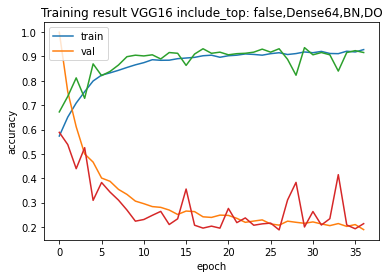

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Training result VGG16 include_top: false,Dense64,BN,DO')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.savefig('training_pustular_excoriated_aug_vgg16.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
print(f'The first 10 predictions: {pred[:]}')

from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

The first 10 predictions: ['pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular', 'pustular']
Accuracy on the test set: 50.00%
              precision    recall  f1-score   support

  excoriated       1.00      0.00      0.00         9
    pustular       0.50      1.00      0.67         9

    accuracy                           0.50        18
   macro avg       0.75      0.50      0.33        18
weighted avg       0.75      0.50      0.33        18



In [15]:
model.save("model_acne_pusutlar_excoriated_2.h5")

In [17]:
model = tf.keras.models.load_model('model_acne_pusutlar_excoriated_2.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [
                           tf.lite.Optimize.OPTIMIZE_FOR_SIZE,
                           tf.lite.Optimize.DEFAULT
                           ]
                          
tflite_quant_model = converter.convert()

with open('model_acne_pustular_excoriated_latest_2.tflite', 'wb') as f:
  f.write(tflite_quant_model)


INFO:tensorflow:Assets written to: /tmp/tmp41dj9xub/assets


INFO:tensorflow:Assets written to: /tmp/tmp41dj9xub/assets


In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   